# 1.2 import dependencies

In [1]:
import cv2
import os
import random
import numpy as np 
from matplotlib import  pyplot as plt

### tensorflow imports

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [15]:
# limita uso de gpu
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
    # tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# pastas
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [23]:
# cria pastas
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2.1 Collet Positives and Anchors

## 2.1 Untar Labelled daces

In [1]:
# descomprime
!tar -xf lfw.tgz 

In [8]:
# mode imgs to the negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Colecting and saving images

In [5]:
import uuid

In [18]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[120:120+250, 200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# Load and Preprocess Images

## 3.1 get imgs directores

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

## 3.2 Preprocessing - Scale and Resize

In [8]:
def preprocess (file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [10]:
img = preprocess('data/anchor/029ee87c-4931-11ec-9672-e09467e2e08c.jpg')

In [11]:
img.numpy().max()

0.8384804

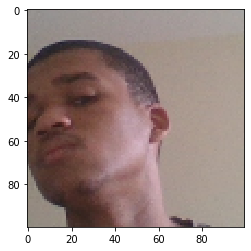

In [12]:
plt.imshow(img)

## 3.2 Create Labelled Datset

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
example = samples.next()

In [16]:
example

(b'data/anchor/feed75cc-4930-11ec-9672-e09467e2e08c.jpg',
 b'data/positive/a7aa42a4-4930-11ec-9672-e09467e2e08c.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*example)

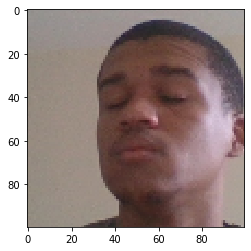

In [19]:
plt.imshow(res[0])

In [20]:
res[2]

1.0

In [11]:
#build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [12]:
samples = data.as_numpy_iterator()

In [13]:
samp = samples.next()

2021-11-20 08:47:15.766858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-20 08:47:15.808783: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


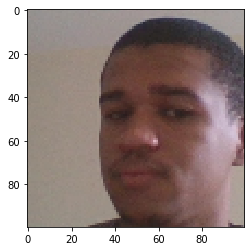

In [107]:
plt.imshow(samp[0])

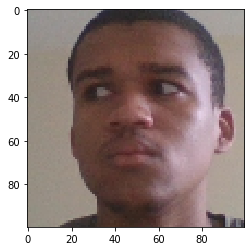

In [108]:
plt.imshow(samp[1])

In [109]:
samp[2]

1.0

In [50]:
round(len(data)*.7)

420

In [14]:
# training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
train_samples = train_data.as_numpy_iterator()

In [58]:
train_sample = train_samples.next()

In [59]:
len(train_sample[0])

16

In [60]:
round(len(data)*.3)

180

In [16]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4 Model Engineering

4.1 Build Embedding layer

In [17]:
inp = Input(shape=(100, 100, 3), name='input_image')

In [19]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)

In [20]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [21]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [22]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [23]:
c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
f1= Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [24]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0 

In [26]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # 1º bloko
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # 2º bloko
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # 3º bloko
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # 4º bloko final embedding 
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1= Flatten()(c4) 
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [27]:
embedding = make_embedding()

In [28]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build distance layer

In [29]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic  happens here 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [30]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [31]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [32]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [34]:
siamese_layer = L1Dist()

In [35]:
distances = siamese_layer(inp_embedding, val_embedding)

In [36]:
classifier = Dense(1, activation='sigmoid')(distances)

In [37]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [38]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [39]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [40]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Cmobine siamese distance componentes
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_model = make_siamese_model()

In [42]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# Training

## 5.1 Loss and Optimizer

In [43]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [44]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Estabilish Checkpoint

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [46]:
test_batch = train_data.as_numpy_iterator() 

In [47]:
batch_1 = test_batch.next()

In [48]:
X = batch_1[:2]

In [49]:
y = batch_1[2]

In [50]:
y

array([0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [120]:
tf.losses.BinaryCrossentropy??

In [51]:
@tf.function
def train_step(batch):
    
    #Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        
        # Get  label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    # Calculate gradientes
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # return loss
    return loss

## 5.4 Training Loop

In [52]:
def train(data, EPOCHS):
    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through eaach batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train d model

In [54]:
EPOCHS = 50

In [55]:
train(train_data, EPOCHS)


 EPOCH 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 290s 11s/step

 EPOCH 2/50
27/27 [==============================] - 273s 10s/step

 EPOCH 3/50
27/27 [==============================] - 272s 10s/step

 EPOCH 4/50
27/27 [==============================] - 298s 11s/step

 EPOCH 5/50
27/27 [==============================] - 273s 10s/step

 EPOCH 6/50
27/27 [==============================] - 311s 12s/step

 EPOCH 7/50
27/27 [==============================] - 339s 13s/step

 EPOCH 8/50
27/27 [==============================] - 411s 15s/step

 EPOCH 9/50
27/27 [==============================] - 375s 14s/step

 EPOCH 10/50
27/27 [==============================] - 269s 10s/step

 EPOCH 11/50
27/27 [==============================] - 270s 10s/step

 EPOCH 12/50
27/27 [==============================] - 286s 11s/step

 EPOCH 13/50
27/27 [======

# 6 Evaluate Model

In [61]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make predictions

In [56]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# dps pa conpila apartir de li

In [57]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9998057e-01],
       [1.0000000e+00],
       [9.9999690e-01],
       [5.2854652e-08],
       [1.1052010e-11],
       [2.0661368e-09],
       [9.9999982e-01],
       [1.0000000e+00],
       [9.9949372e-01],
       [1.0000000e+00],
       [9.9993408e-01],
       [7.0414646e-12],
       [9.9976140e-01],
       [1.0640277e-11],
       [1.9547558e-11],
       [2.5576600e-11]], dtype=float32)

In [58]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]

In [59]:
y_true

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

##  6.3 Calculate Metrics

In [62]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Retur Recall Result
m.result().numpy()

1.0

In [63]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

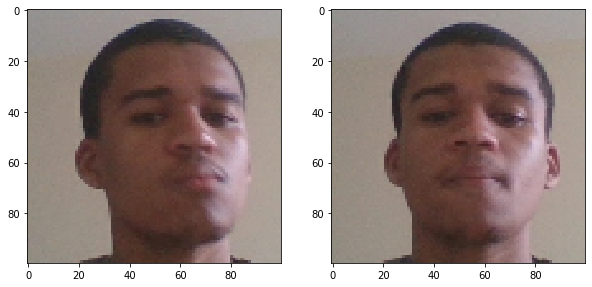

In [64]:
# set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1, 2 ,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7 Save Model

In [65]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [66]:
L1Dist

__main__.L1Dist

In [67]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                  custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [68]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[9.9998057e-01],
       [1.0000000e+00],
       [9.9999690e-01],
       [5.2854652e-08],
       [1.1052010e-11],
       [2.0661368e-09],
       [9.9999982e-01],
       [1.0000000e+00],
       [9.9949372e-01],
       [1.0000000e+00],
       [9.9993408e-01],
       [7.0414646e-12],
       [9.9976140e-01],
       [1.0640277e-11],
       [1.9547558e-11],
       [2.5576600e-11]], dtype=float32)

In [69]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8 Real time test

## 8.1 Verification Function

In [70]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [71]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0a2f9082-4931-11ec-9672-e09467e2e08c.jpg',
 '0ad6d0ea-4931-11ec-9672-e09467e2e08c.jpg',
 '0a39f1da-4931-11ec-9672-e09467e2e08c.jpg',
 '00af4bc4-4931-11ec-9672-e09467e2e08c.jpg',
 '0a85a27e-4931-11ec-9672-e09467e2e08c.jpg',
 '0a0c2ee4-4931-11ec-9672-e09467e2e08c.jpg',
 '00be9caa-4931-11ec-9672-e09467e2e08c.jpg',
 '00c3711c-4931-11ec-9672-e09467e2e08c.jpg',
 '0a900854-4931-11ec-9672-e09467e2e08c.jpg',
 '0acc74b0-4931-11ec-9672-e09467e2e08c.jpg',
 '0a25e4c4-4931-11ec-9672-e09467e2e08c.jpg',
 '00dd177a-4931-11ec-9672-e09467e2e08c.jpg',
 '0a02705c-4931-11ec-9672-e09467e2e08c.jpg',
 '0a765fb2-4931-11ec-9672-e09467e2e08c.jpg',
 '0a99c3b2-4931-11ec-9672-e09467e2e08c.jpg',
 '00aa6ed8-4931-11ec-9672-e09467e2e08c.jpg',
 '00d2fae2-4931-11ec-9672-e09467e2e08c.jpg',
 '0a6c9dec-4931-11ec-9672-e09467e2e08c.jpg',
 '0ac21218-4931-11ec-9672-e09467e2e08c.jpg',
 '0a9eb2fa-4931-11ec-9672-e09467e2e08c.jpg',
 '0aa42e2e-4931-11ec-9672-e09467e2e08c.jpg',
 '0a168de4-4931-11ec-9672-e09467e2e08c.jpg',
 '0a624004

In [72]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [74]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/0a2f9082-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0ad6d0ea-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0a39f1da-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/00af4bc4-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0a85a27e-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0a0c2ee4-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/00be9caa-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/00c3711c-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0a900854-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0acc74b0-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0a25e4c4-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/00dd177a-4931-11ec-9672-e09467e2e08c.jpg
application_data/verification_images/0a02705c-4931-11ec-9672-e09

In [89]:
def verify(model, detection_threshold, verification_threshold):
    
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection threshold: Metric above wich a prediction is considered positive
    detection = np .sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection /len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV real time verefication

In [92]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        # save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

True
True
True


In [91]:
cap.release()
cv2.destroyAllWindows()